1. Используя признаки, отобранные взаимной информацией, RFE и PI, посмотрите качество XGBoost'а по аналогии с тем, как это делалось на уроке. При каком подходе к отбору признаков получается лучшее значение F1?
2. Обучите любые две другие модели для предсказания оттока для любом из отобранных множеств признаков и сравните качество с уже полученными.
3. Постройте матрицу корреляций и предложите отбор признаков на основании этой матрицы.
4. __(*)__ Как думаете, можно ли производить отбор признаков с помощью IV, а затем обучать модель случайного леса на отфильтрованном датасете? Ответ обоснуйте. 

### 1. Используя признаки, отобранные взаимной информацией, RFE и PI, посмотрите качество XGBoost'а по аналогии с тем, как это делалось на уроке. При каком подходе к отбору признаков получается лучшее значение F1?

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from scipy import interp
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.feature_selection import chi2, mutual_info_classif, RFECV
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, auc, \
                            log_loss, roc_auc_score, average_precision_score, confusion_matrix

def evaluation(y_true, y_pred, y_prob):
    precision = precision_score(y_true=y_true, y_pred=y_pred)
    recall = recall_score(y_true=y_true, y_pred=y_pred)
    f1 = f1_score(y_true=y_true, y_pred=y_pred)
    ll = log_loss(y_true=y_true, y_pred=y_prob)
    roc_auc = roc_auc_score(y_true=y_true, y_score=y_prob)
    print('Precision: {}'.format(precision))
    print('Recall: {}'.format(recall))
    print('F1: {}'.format(f1))
    print('Log Loss: {}'.format(ll)) 
    print('ROC AUC: {}'.format(roc_auc)) 
    return precision, recall, f1, ll, roc_auc

def xgb_fit_predict(X_train, y_train, X_test, y_test):
    clf = xgb.XGBClassifier(max_depth=3,
                            n_estimators=100,
                            learning_rate=0.1,
                            nthread=5,
                            subsample=1.,
                            colsample_bytree=0.5,
                            min_child_weight = 3,
                            reg_alpha=0.,
                            reg_lambda=0.,
                            seed=42,
                            missing=1e10)

    clf.fit(X_train, y_train, eval_metric='aucpr', verbose=10)
    predict_proba_test = clf.predict_proba(X_test)
    predict_test = clf.predict(X_test)
    precision_test, recall_test, f1_test, log_loss_test, roc_auc_test = \
        evaluation(y_test, predict_test, predict_proba_test[:, 1])
    return clf

def plot_importance(importance, features, name):
    fi = pd.DataFrame(list(zip(features, importance))).sort_values(by=1, ascending=False)
    plt.figure(figsize=(16,6))
    plt.bar(range(fi.shape[0]), fi[1], align='center')
    plt.xticks(range(fi.shape[0]), fi[0], rotation=90)
    plt.title(name)
    plt.show()
    return fi

Using TensorFlow backend.


In [2]:
%%time
dataset = pd.read_csv('dataset/dataset_train.csv', sep=';')
X = dataset.drop(['user_id', 'is_churned'], axis=1)
y = dataset['is_churned']

X_mm = MinMaxScaler().fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_mm, 
                                                    y, 
                                                    test_size=0.3,
                                                    shuffle=True, 
                                                    stratify=y, 
                                                    random_state=100)

# Снизим дизбаланс классов
X_train_balanced, y_train_balanced = SMOTE(random_state=42, ratio=0.3).fit_sample(X_train, y_train)

Wall time: 12.4 s


#### Взаимная информация

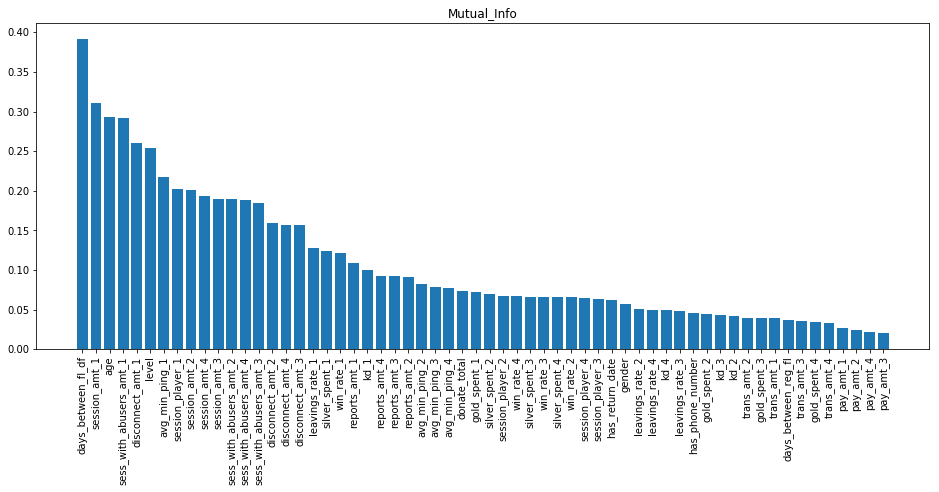

Wall time: 9min 13s


In [5]:
%%time
mi = mutual_info_classif(X_train_balanced, y_train_balanced)
feature_importance = plot_importance(mi, X.columns, 'Mutual_Info')

In [6]:
X_train_MI = pd.DataFrame(X_train_balanced, columns=X.columns)[feature_importance[0][:30]]
X_test_MI = pd.DataFrame(X_test, columns=X.columns)[feature_importance[0][:30]]

fitted_clf = xgb_fit_predict(X_train_MI, y_train_balanced, X_test_MI, y_test)

print('Признаков было:', X_train.shape[1])
print('Признаков стало:', X_train_MI.shape[1])

Precision: 0.2931657772422104
Recall: 0.4105593056894889
F1: 0.3420709048910315
Log Loss: 0.13344928679295354
ROC AUC: 0.8942447107626829
Признаков было: 60
Признаков стало: 30


#### RFE (Recursive Feature Elimination)

In [7]:
%%time
STEP = 5
logit = LogisticRegression(random_state=42)

selector = RFECV(estimator=logit, step=STEP, cv=StratifiedKFold(2), scoring='f1')
selector.fit(X_train_balanced, y_train_balanced)

good_features = X.columns[selector.support_]
print("Optimal number of features : %d" % selector.n_features_)

Optimal number of features : 45
Wall time: 1min 54s


In [10]:
X_train_RFE = pd.DataFrame(X_train_balanced, columns=X.columns)[good_features]
X_test_RFE = pd.DataFrame(X_test, columns=X.columns)[good_features]

fitted_clf = xgb_fit_predict(X_train_RFE, y_train_balanced, X_test_RFE, y_test)

print('Признаков было:', X_train.shape[1])
print('Признаков стало:', X_train_RFE.shape[1])

Precision: 0.29100442405374405
Recall: 0.42815814850530376
F1: 0.3465027802165642
Log Loss: 0.13367615552215684
ROC AUC: 0.8988914374585346
Признаков было: 60
Признаков стало: 45


#### Permutation Importance (PI)

In [3]:
from ELI5 import PermutationImportance

In [4]:
fitted_clf = xgb_fit_predict(X_train_balanced, y_train_balanced, X_test, y_test)

Precision: 0.29624109951978805
Recall: 0.43129218900675026
F1: 0.3512319623048984
Log Loss: 0.1331765372711698
ROC AUC: 0.8987815259834706


In [5]:
%%time
perm = PermutationImportance(fitted_clf, random_state=42).fit(X_train_balanced, y_train_balanced)

res = pd.DataFrame(X.columns, columns=['feature'])
res['score'] = perm.feature_importances_
res['std'] = perm.feature_importances_std_
res = res.sort_values(by='score', ascending=False).reset_index(drop=True)

Wall time: 5min 46s


In [6]:
X_train_PI = pd.DataFrame(X_train_balanced, columns=X.columns)[list(res["feature"][0:30])]
X_test_PI = pd.DataFrame(X_test, columns=X.columns)[list(res["feature"][0:30])]

fitted_clf = xgb_fit_predict(X_train_PI, y_train_balanced, X_test_PI, y_test)

print('Признаков было:', X_train.shape[1])
print('Признаков стало:', X_train_PI.shape[1])

Precision: 0.2875098193244305
Recall: 0.4411764705882353
F1: 0.3481403976029677
Log Loss: 0.1343071161105287
ROC AUC: 0.9004361512581963
Признаков было: 60
Признаков стало: 30


#### Вывод:

In [25]:
#  MI F1: 0.3420709048910315 
# RFE F1: 0.3465027802165642
#  PI F1: 0.3481403976029677

Лучшее F1 получилось при использовании перемешения Permutation Importance (PI).

### 2. Обучите любые две другие модели для предсказания оттока для любом из отобранных множеств признаков и сравните качество с уже полученными.

#### LogisticRegression

In [7]:
from sklearn.linear_model import LogisticRegression

In [9]:
clf = LogisticRegression(random_state=0).fit(X_train_PI, y_train_balanced)

In [10]:
predict_proba_test = clf.predict_proba(X_test_PI)
predict_test = clf.predict(X_test_PI)
precision_test, recall_test, f1_test, log_loss_test, roc_auc_test = \
    evaluation(y_test, predict_test, predict_proba_test[:, 1])

Precision: 0.20382824624935333
Recall: 0.2849566055930569
F1: 0.23765959585804766
Log Loss: 0.25759541095861654
ROC AUC: 0.7760777139259731


F1 заметно ниже при использовании модели логистической регрессии по сравнению с XGBoost'ом.

#### RandomForestClassifier

In [11]:
from sklearn.ensemble import RandomForestClassifier

In [12]:
clf = RandomForestClassifier(max_depth=2, random_state=0).fit(X_train_PI, y_train_balanced)

In [13]:
predict_proba_test = clf.predict_proba(X_test_PI)
predict_test = clf.predict(X_test_PI)
precision_test, recall_test, f1_test, log_loss_test, roc_auc_test = \
    evaluation(y_test, predict_test, predict_proba_test[:, 1])

Precision: 0.2731034482758621
Recall: 0.04773384763741562
F1: 0.08126410835214448
Log Loss: 0.23219261362223745
ROC AUC: 0.8703752393737221


F1 крайне низкий, хотя ROC AUC довольно высок. Результат так же хуже, чем использование более современного алгоритма градиентного бустинга.

### 3. Постройте матрицу корреляций и предложите отбор признаков на основании этой матрицы.

In [30]:
corr = dataset.corr()['is_churned']

In [42]:
list(abs(corr).sort_values(ascending=False)[1:31].index)

['session_amt_4',
 'session_amt_3',
 'session_player_4',
 'level',
 'session_player_3',
 'sess_with_abusers_amt_4',
 'sess_with_abusers_amt_3',
 'session_amt_2',
 'session_player_2',
 'sess_with_abusers_amt_2',
 'reports_amt_4',
 'reports_amt_3',
 'reports_amt_2',
 'has_return_date',
 'sess_with_abusers_amt_1',
 'trans_amt_4',
 'session_player_1',
 'trans_amt_2',
 'win_rate_4',
 'reports_amt_1',
 'trans_amt_3',
 'donate_total',
 'trans_amt_1',
 'silver_spent_4',
 'silver_spent_3',
 'pay_amt_2',
 'pay_amt_4',
 'win_rate_3',
 'pay_amt_3',
 'silver_spent_2']

In [43]:
X_train_Corr = pd.DataFrame(X_train_balanced, columns=X.columns)[list(abs(corr).sort_values(ascending=False)[1:31].index)]
X_test_Corr = pd.DataFrame(X_test, columns=X.columns)[list(abs(corr).sort_values(ascending=False)[1:31].index)]

fitted_clf = xgb_fit_predict(X_train_PI, y_train_balanced, X_test_PI, y_test)

print('Признаков было:', X_train.shape[1])
print('Признаков стало:', X_train_Corr.shape[1])

Precision: 0.2875098193244305
Recall: 0.4411764705882353
F1: 0.3481403976029677
Log Loss: 0.1343071161105287
ROC AUC: 0.9004361512581963
Признаков было: 60
Признаков стало: 30


Идея в том, чтобы оставить только те признаки, которые хорошо коррелируют с целевой переменной. Я отобрал 30 лучших, и результат получился точно такой же, как и в случае Permutation Importance. Иначе можно было бы задать какую-то границу и брать признаки, у которых модуль корреляции с целевой переменной больше этой границы.

### 4. __(*)__ Как думаете, можно ли производить отбор признаков с помощью IV, а затем обучать модель случайного леса на отфильтрованном датасете? Ответ обоснуйте. 

https://www.listendata.com/2015/03/weight-of-evidence-woe-and-information.html
Судя по тому, что я нарыл, мало смысла отбирать признаки с помощь IV, а затем это использовать модель, отличную от бинарной логистической регрессии. По сути можно сказать, что IV - это мера, которая показывать, насколько хорошо выбранный признак различает бинарное целевое значение. В деревянных алгоритмах может возникнуть ситуация, когда один и тот же признак в разных ветках по разному коррелирует с целевой переменной, так что считать IV не целесообразно.
С другой стороны, если у нас задача бинарной классификации и мы испольуем IV только для того, чтобы выбрать лучше N признаков, то, я считаю, это должно работать примерно на таком же уровне, как и другие алгоритмы выбора признаков, а именно я сравнил бы его с подсчётом корреляции (пункт 3 этого ДЗ).